**This demo uses dataset of raw T1 structual MRI images. ABIDE dataset.**

- 573 subjects on control in total.<p>
- from 6 to 56 years old.<p>
- 10% for test, 90% for training.<p>
- final input dimension: (67,67,67), pixdim = (4,4,4)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import sys
sys.path.append("..")
from dev_tools.my_tools import *
from dev_tools.model_tools import *

# The raw image

## Some images looks like this:

0
1138
0


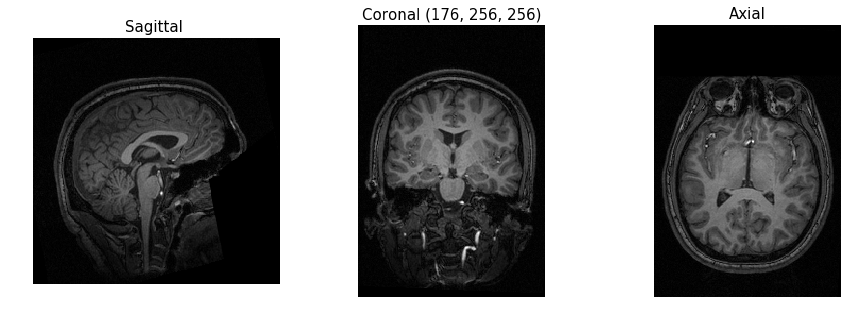

In [3]:
nii_img = nib.load('/media/woody/Elements/age_data/ABIDE_I/anat_data/50002.nii.gz')
npy_img = nii_img.get_data()
print2d(npy_img)

## It goes through the resampling and padding process

0.0210727969348659
1.0
0.0


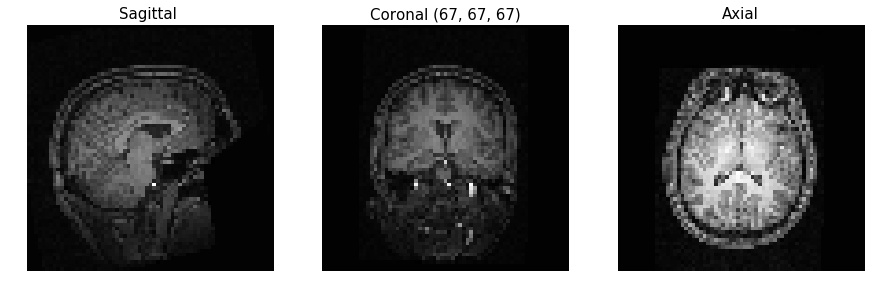

In [4]:
crop_padded_img = np.load('./data_npy/origin/50002.npy')
print2d(crop_padded_img)

## The mean image of all the training data is computed and is subtracted from all training and test data.
It is worth noting that the test data does not contribute to the mean image. This is because the training data, and only training data, needs to have zero mean for better training performance.
## How does the mean values look like:

0.0577161821630785
0.3634533093696365
0.057659670749484554
0.02675384493857924
0.19231456020724347
0.02605890367619765
-0.0366433852282126
0.7721857455906828
-0.25849865036740327


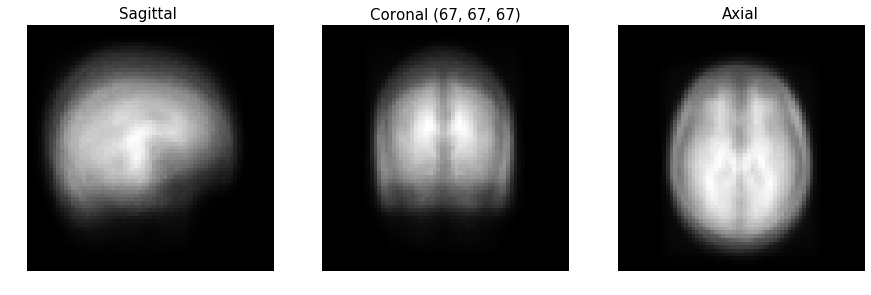

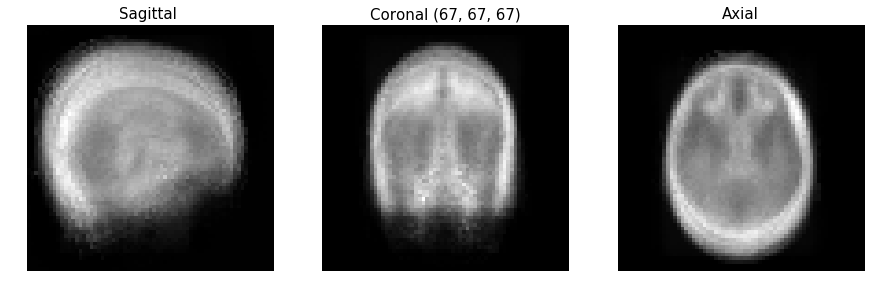

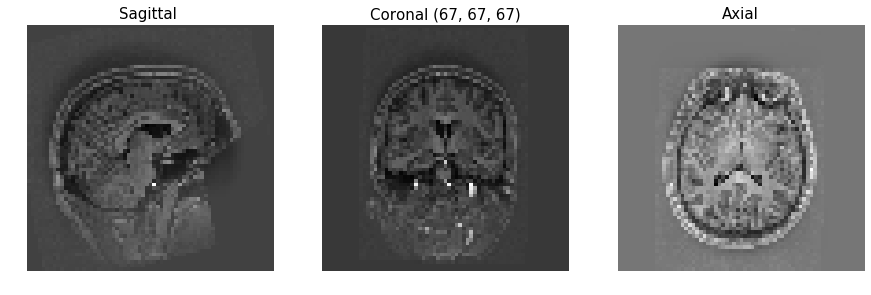

In [11]:
mean_npy = np.load('./data_npy/mean_npy.npy')
print2d(mean_npy)
std_npy = np.load('./data_npy/std_npy.npy')
print2d(std_npy)
print2d(crop_padded_img - mean_npy)

## Finally, the images fed into the model look like this:

-1.3696493088129016
10.032627796246388
-2.3831402541018596


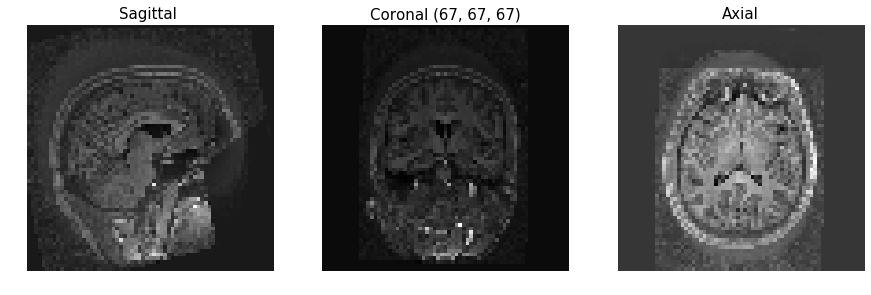

In [12]:
final_img = np.load('./data_npy/mean_subtracted/50002.npy')
print2d(final_img)

# Training and test results

- The validation uses the test dataset.

- Our model uses 3D-CNN with dropout, batch normalization and L2 regularization.
- Target model uses 3D-CNN with dropout.

The training process of Woody's model


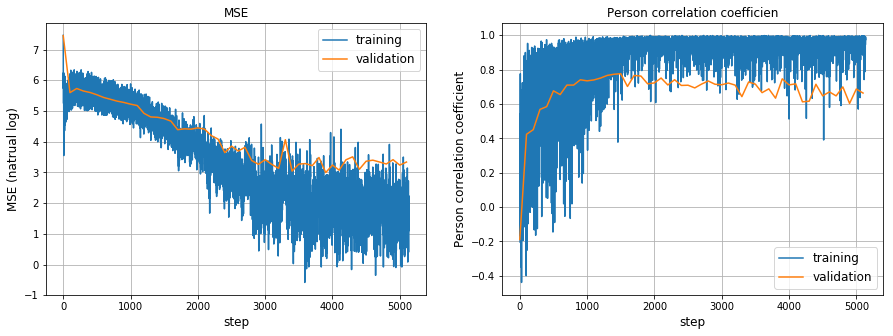

In [15]:
draw_training_proc('./img/training_return_list_woody.npy')
print('The training process of Woody\'s model')

The training process of Zach's modle


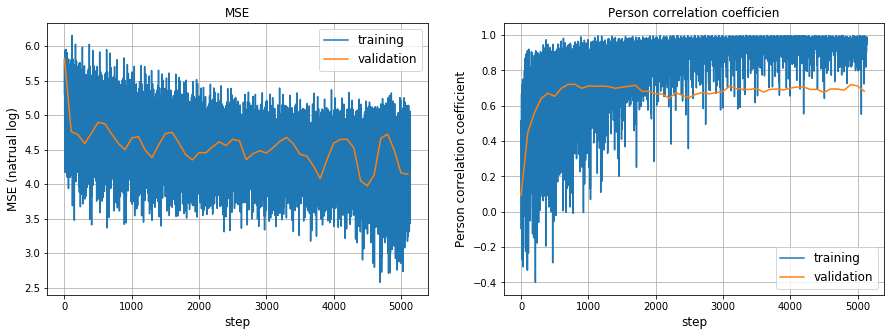

In [18]:
draw_training_proc('./img/training_return_list_zach.npy')
print('The training process of Zach\'s modle')

## Let's check the correlation between the predicted age and the chronological age.

Model woody, best MSE


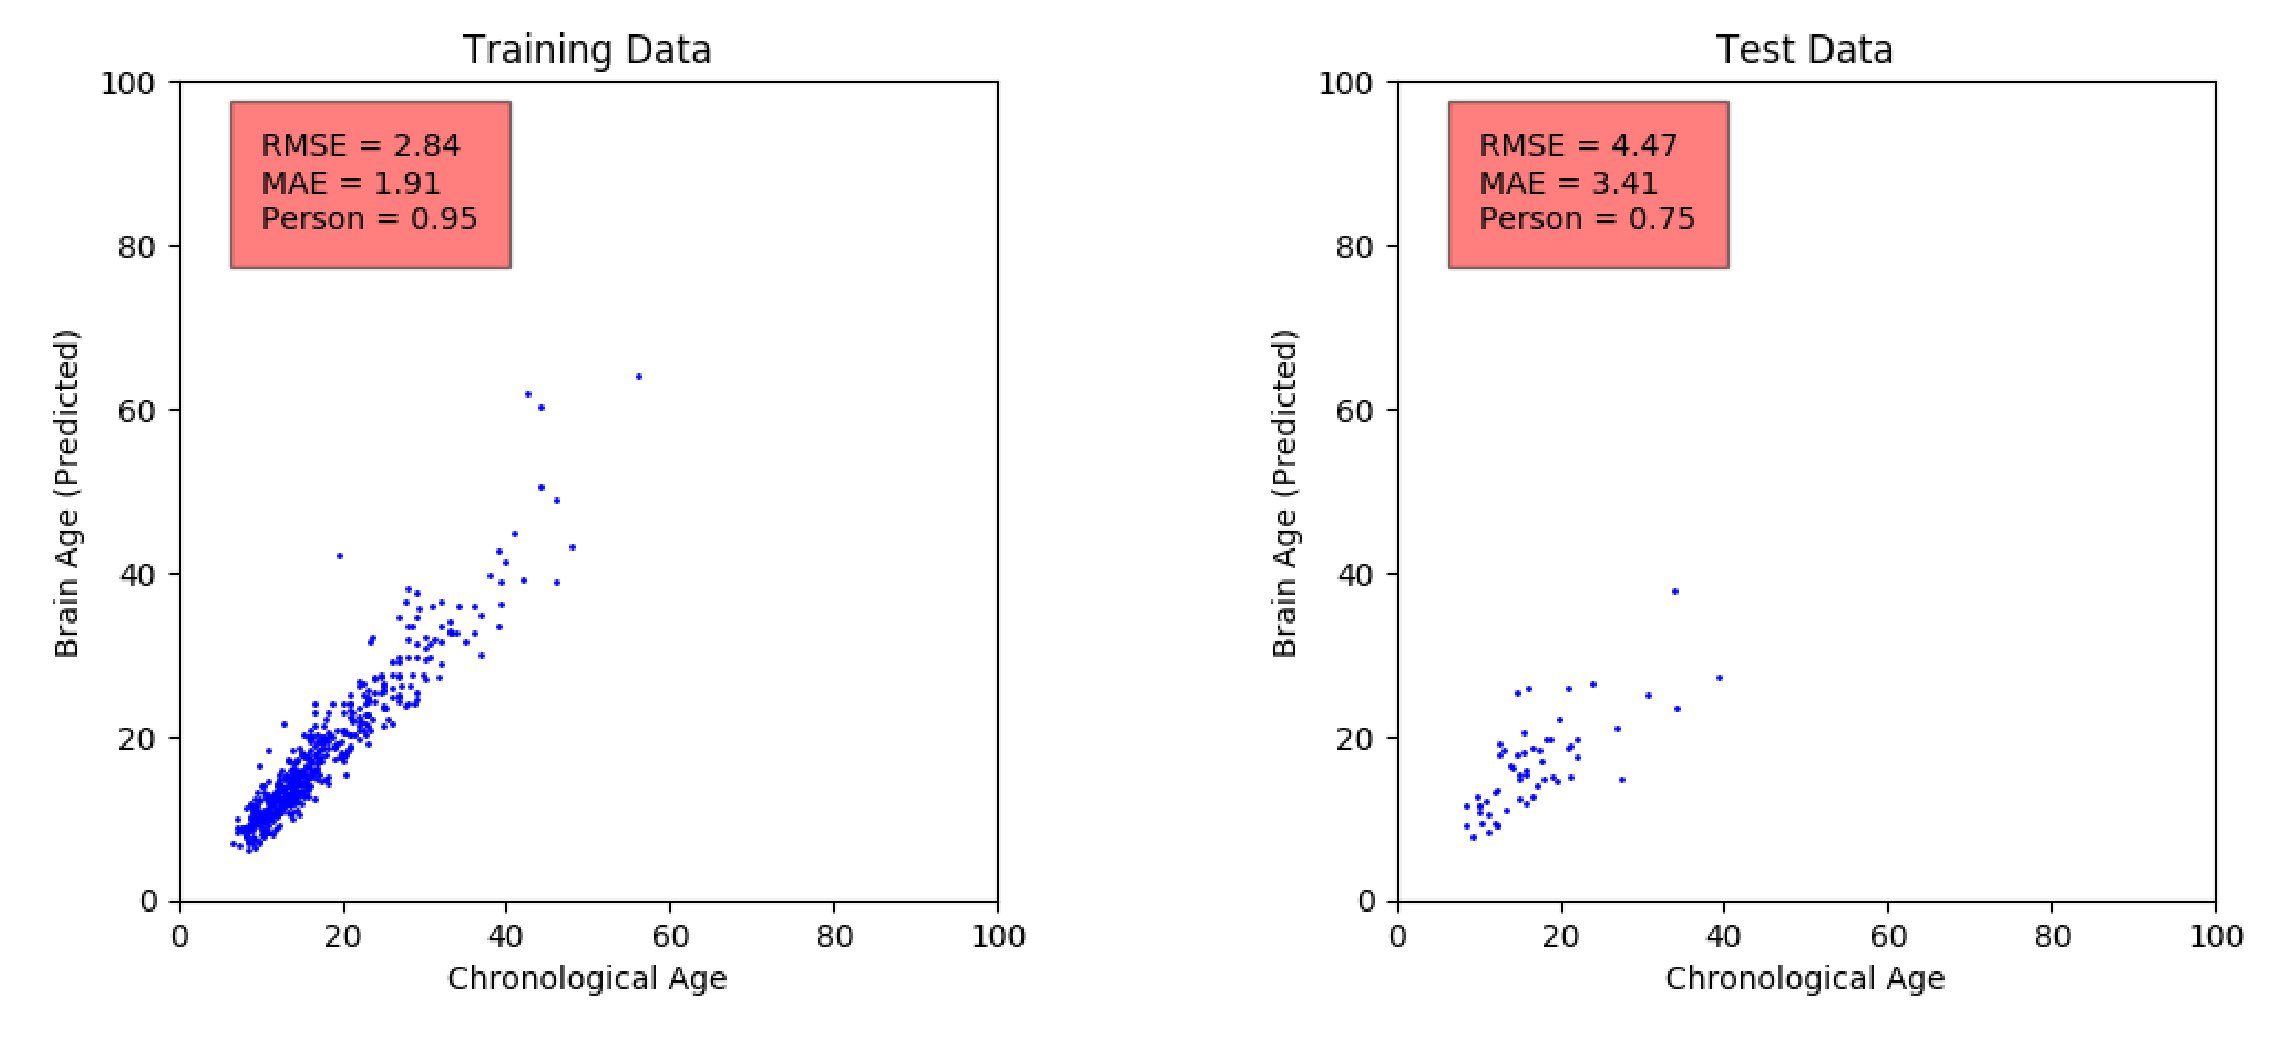

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(plt.imread('./img/training_corr_mse_woody.pdf.png'))
ax1.axis('off')
# ax1.set_title('Training dataset',fontsize=40)
ax2.imshow(plt.imread('./img/test_corr_mse_woody.pdf.png'))
ax2.axis('off')
# ax2.set_title('Test dataset',fontsize=40)
print('Model woody, best MSE')

Model woody, best Person


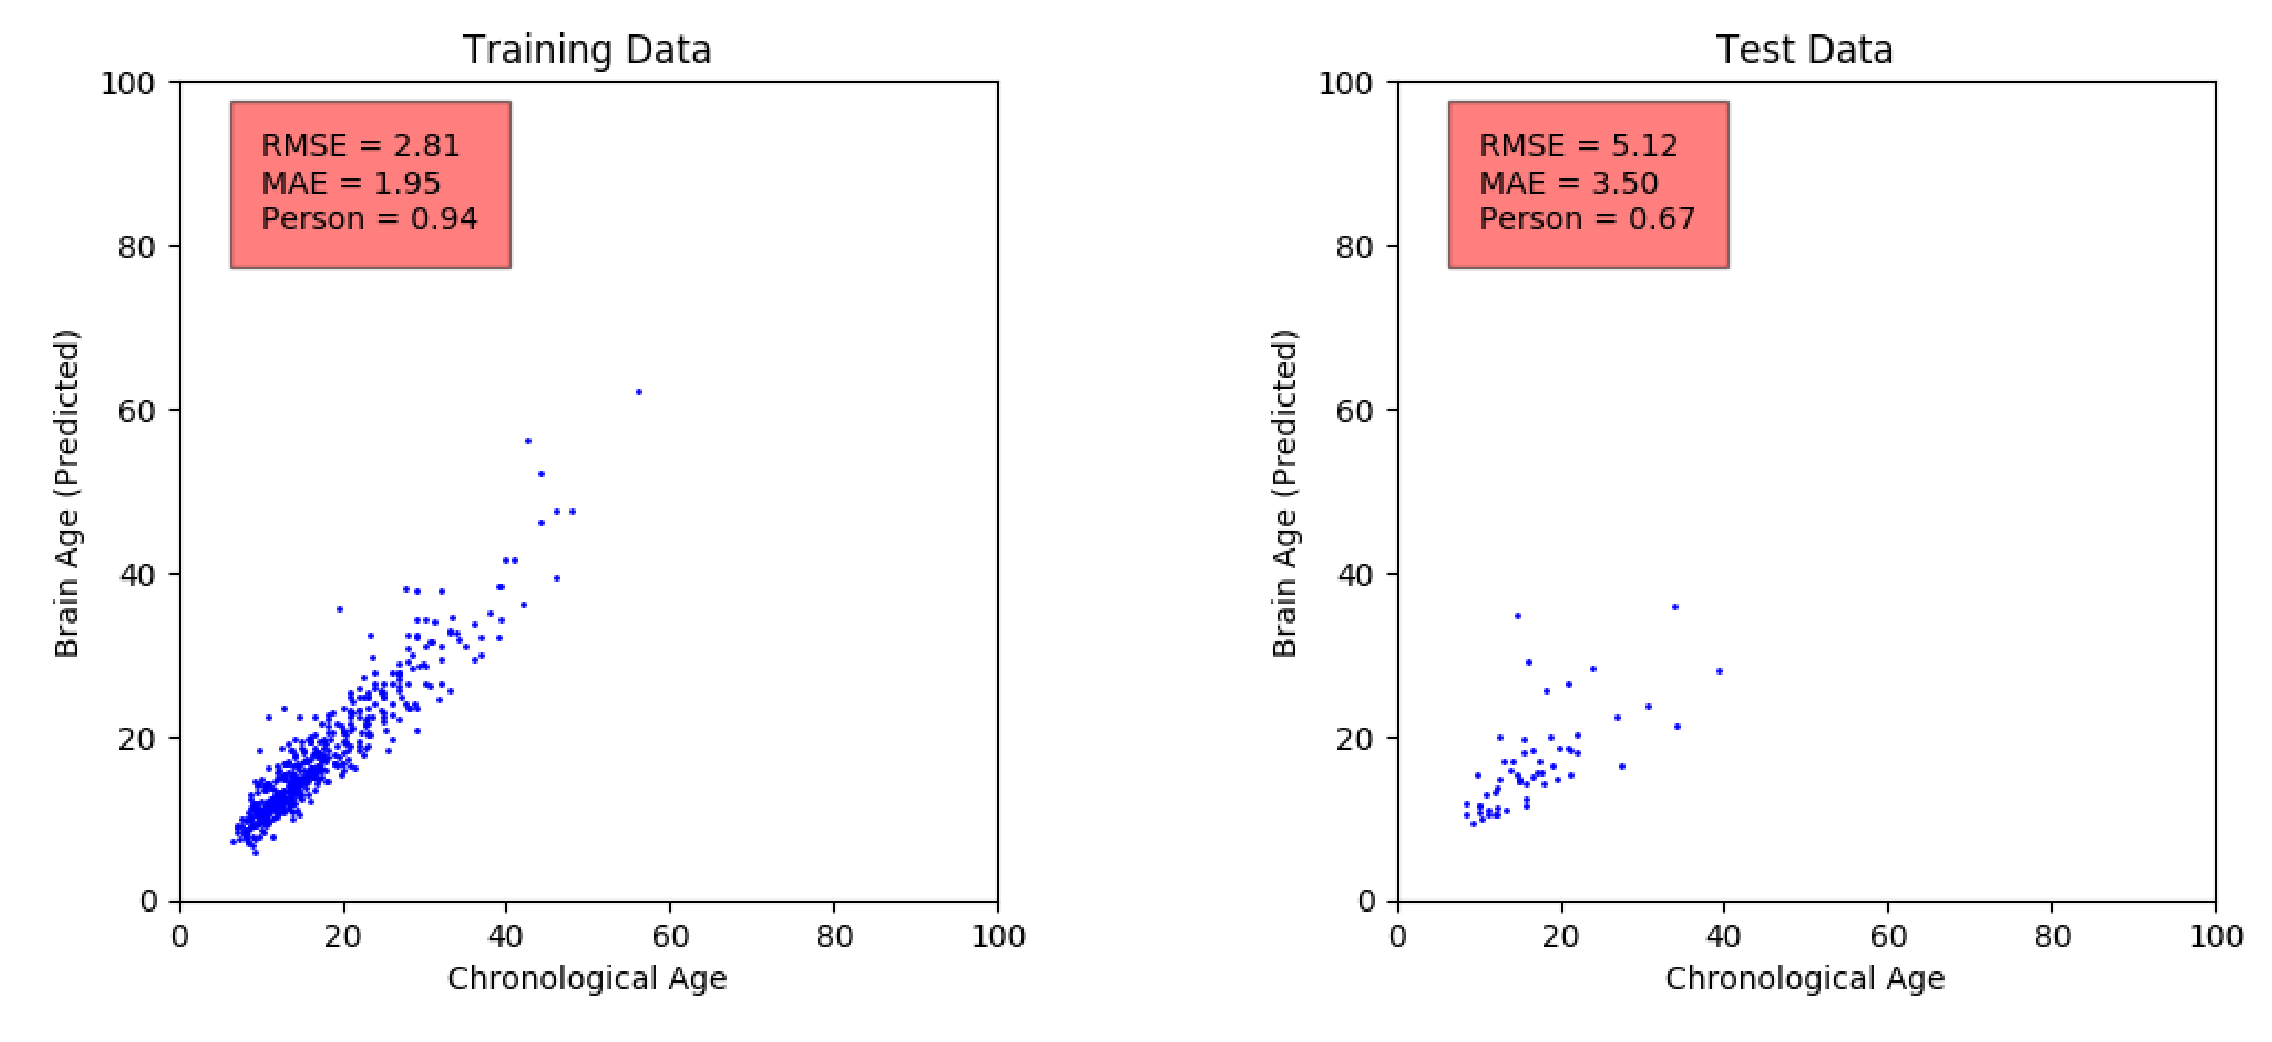

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(plt.imread('./img/training_corr_person_woody.pdf.png'))
ax1.axis('off')
# ax1.set_title('Training dataset',fontsize=40)
ax2.imshow(plt.imread('./img/test_corr_person_woody.pdf.png'))
ax2.axis('off')
# ax2.set_title('Test dataset',fontsize=40)
print('Model woody, best Person')

Model zach, best MSE


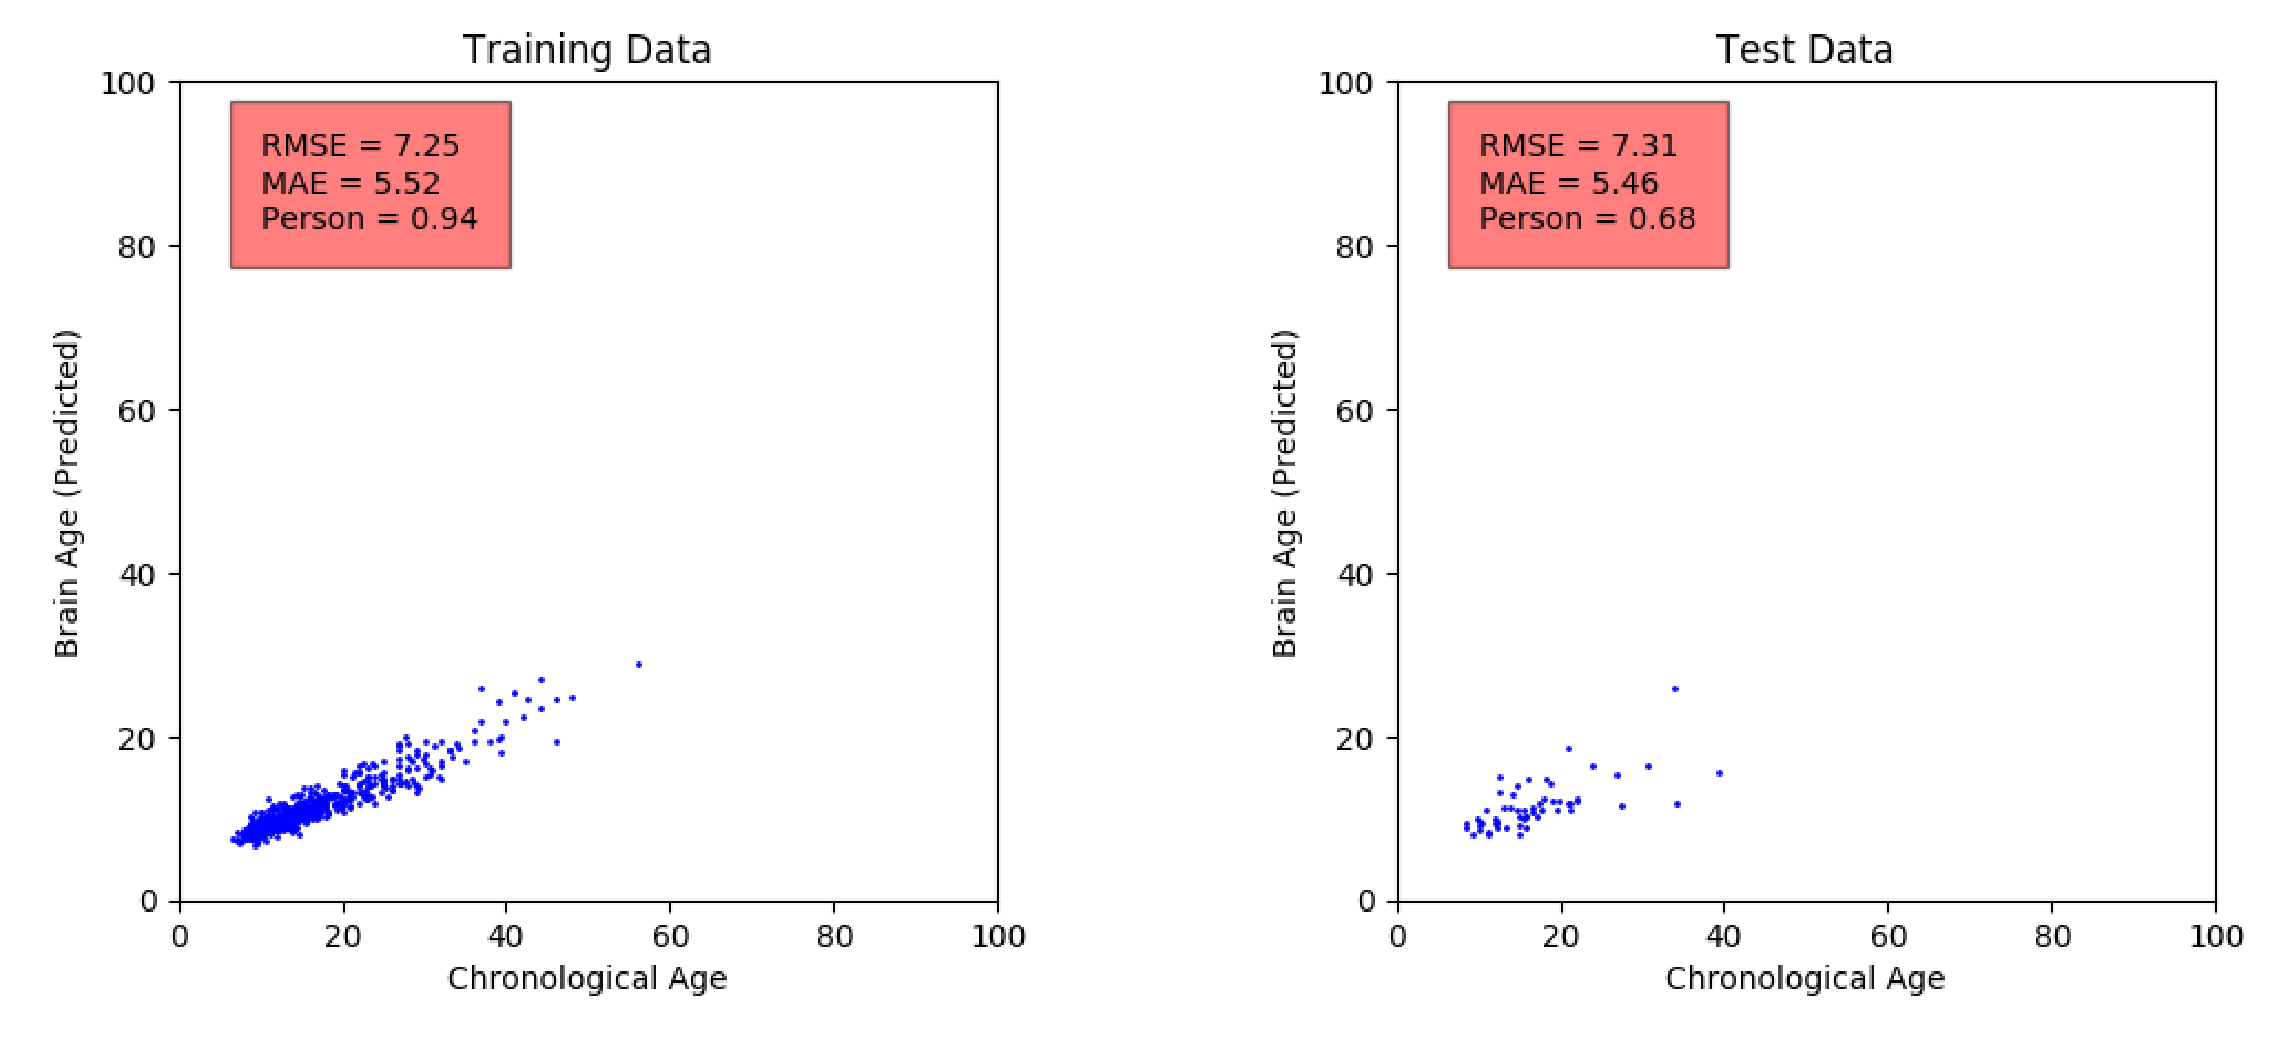

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(plt.imread('./img/training_corr_mse_zach.pdf.png'))
ax1.axis('off')
# ax1.set_title('Training dataset',fontsize=40)
ax2.imshow(plt.imread('./img/test_corr_mse_zach.pdf.png'))
ax2.axis('off')
# ax2.set_title('Test dataset',fontsize=40)
print('Model zach, best MSE')

Model zach, best Person


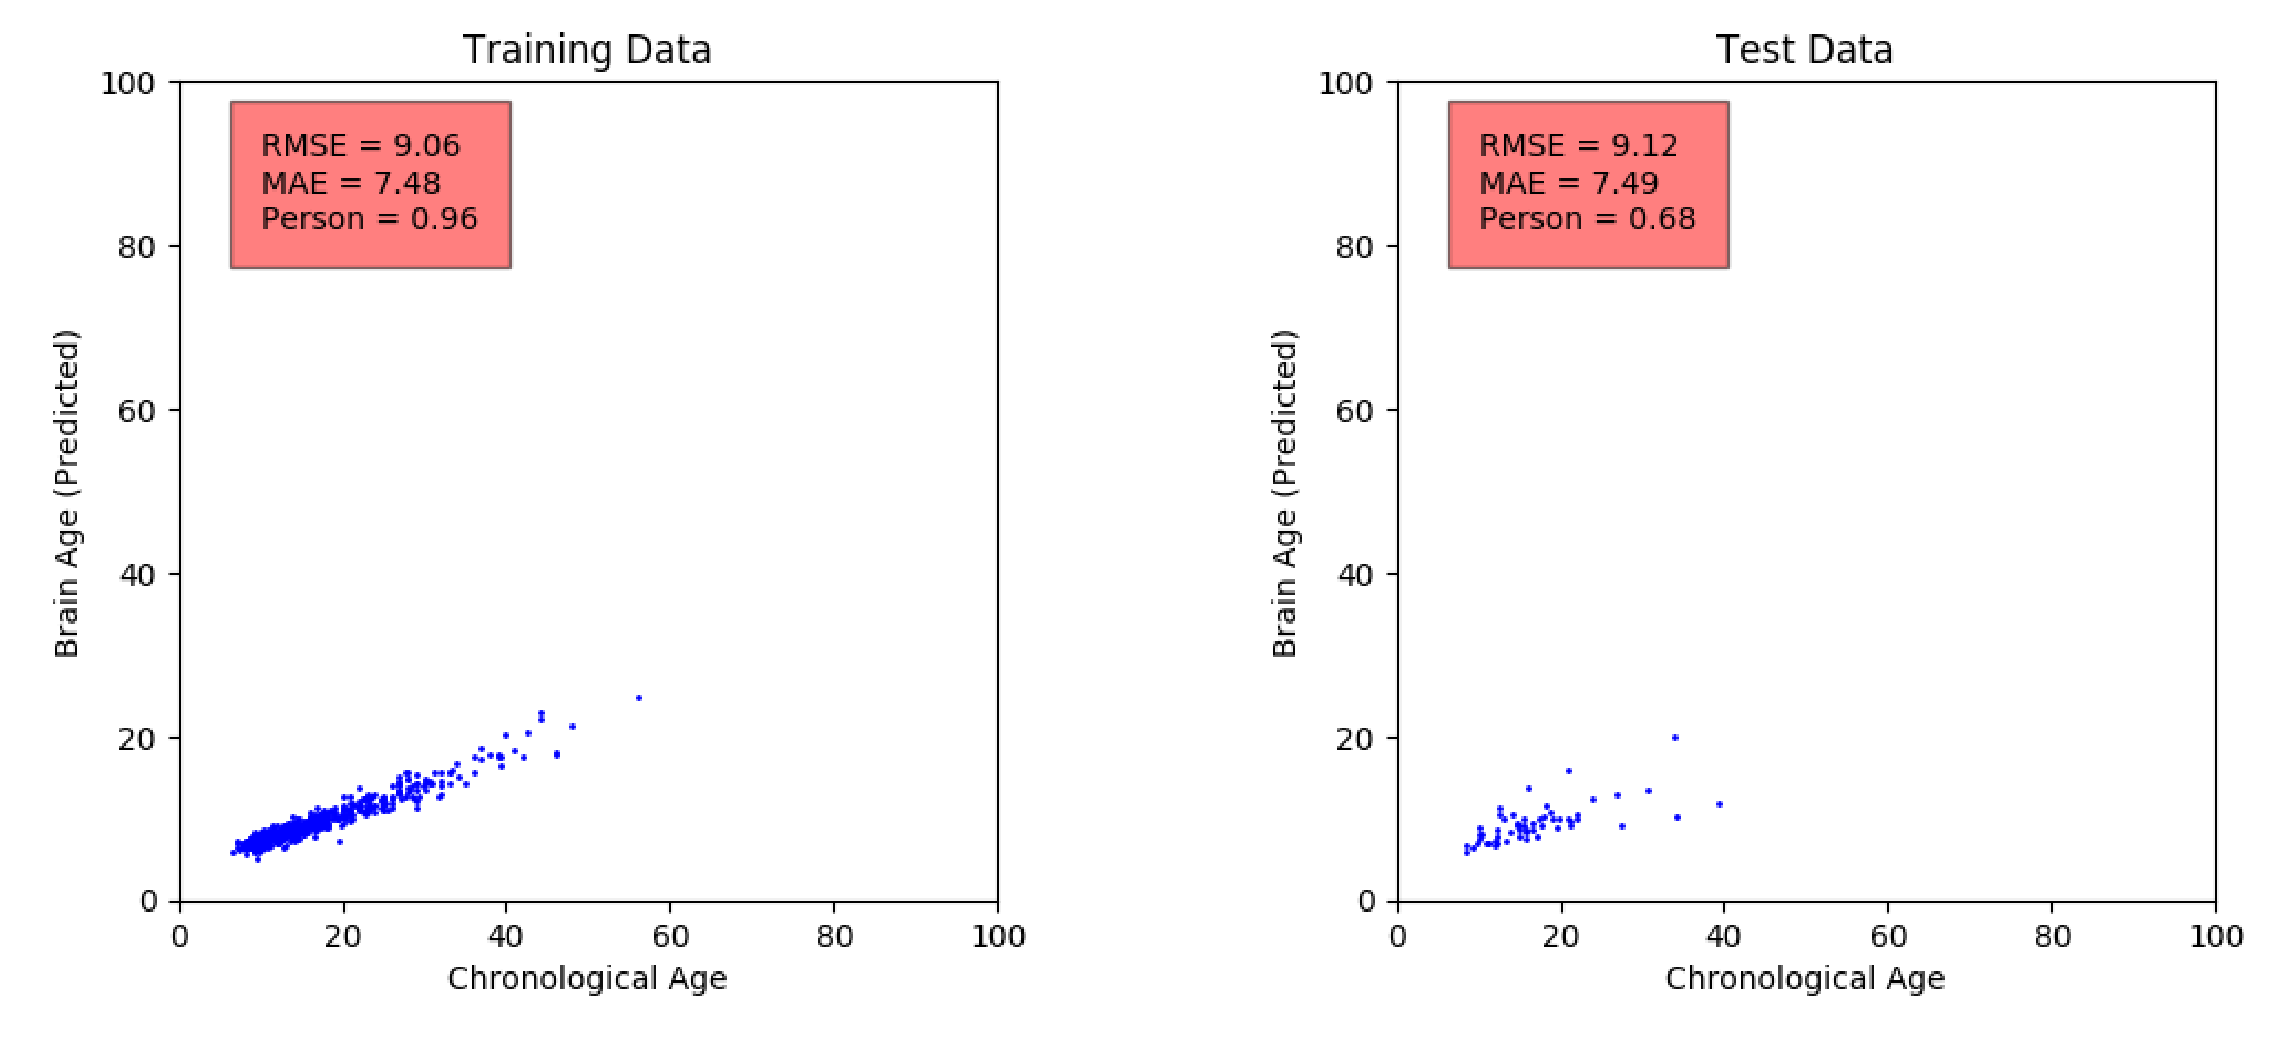

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(plt.imread('./img/training_corr_person_zach.pdf.png'))
ax1.axis('off')
# ax1.set_title('Training dataset',fontsize=40)
ax2.imshow(plt.imread('./img/test_corr_person_zach.pdf.png'))
ax2.axis('off')
# ax2.set_title('Test dataset',fontsize=40)
print('Model zach, best Person')

# Conclusion
## Problem solved


# Appendix:
Predicted age of some test subjects.

In [14]:
# change FLAGS. to constants
def inference(X, keep_prob, is_training_forBN, trivial=True):
    l2_loss = 0
    with tf.name_scope('l1_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([5,5,5,1,16], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[16]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(X,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l2_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,16,32], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[32]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l3_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,32,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l4_conv3d') as scope:
        w = tf.Variable(tf.truncated_normal([3,3,3,64,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l5_conv3d') as scope:  # temp
        w = tf.Variable(tf.truncated_normal([3,3,3,64,64], stddev=0.1), name='kernel')
        b = tf.Variable(tf.constant(0.1,shape=[64]),name='b')
        temp_output = tf.nn.bias_add(tf.nn.conv3d(max_pool,w,strides=[1,1,1,1,1],\
                                                        padding='SAME',name='conv3d'),b)
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        conv3d = tf.nn.relu(temp_output)
        
        max_pool = tf.nn.max_pool3d(conv3d,ksize=[1,2,2,2,1],strides=[1,2,2,2,1],\
                                   padding='SAME',name='max_pool3d')
        
#         l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(conv3d)
            print_activations(max_pool)
    with tf.name_scope('l6_fc') as scope:
        max_pool_shape = max_pool.get_shape().as_list()
        temp_shape = 1
        for i in max_pool_shape[1:]:
            temp_shape *= i
        fc_input = tf.reshape(max_pool, [-1, temp_shape])
        w = tf.Variable(tf.truncated_normal([temp_shape,512],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[512]),name='b')
        temp_output = tf.matmul(fc_input,w) + b
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        fc_out = tf.nn.relu(temp_output, name='fc_out1')
        dropout = tf.nn.dropout(fc_out,keep_prob=keep_prob, name='dropout1')
        
        l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(fc_out)
            print_activations(dropout)
    with tf.name_scope('l7_fc') as scope:
        w = tf.Variable(tf.truncated_normal([512,128],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[128]),name='b')
        temp_output = tf.matmul(fc_out,w) + b
        temp_output = tf.layers.batch_normalization(temp_output,training=is_training_forBN)
        fc_out = tf.nn.relu(temp_output, name='fc_out2')
        dropout = tf.nn.dropout(fc_out,keep_prob=keep_prob, name='dropout2')
        
        l2_loss += tf.nn.l2_loss(w)
        
        if trivial:
            print_activations(fc_out)
            print_activations(dropout)
    with tf.name_scope('l8_fc') as scope:
        w = tf.Variable(tf.truncated_normal([128,1],stddev=0.1),name='w')
        b = tf.Variable(tf.constant(0.1,shape=[1]),name='b')
        
        final_output = tf.add(tf.matmul(dropout,w), b, name='final_output')
        
        l2_loss += tf.nn.l2_loss(w)

        if trivial:
            print_activations(final_output)
    
    return final_output, l2_loss

def test_single_subject(phe_index):
    '''
    '''
#     pdb.set_trace()
    with tf.Graph().as_default():
        phe = pd.read_csv('./phenotypics.csv', sep=',',header=0)
        sub_id = phe['id'][phe_index]
        arr = np.load('./data_npy/mean_subtracted/'+str(int(sub_id))+'.npy')
        arr = arr.astype(np.float32)
        arr_shape = arr.shape
        label = phe['age'][phe_index]
        
        tf_arr = tf.placeholder(tf.float32,shape=arr_shape)
#         tf_label = tf.placeholder(tf.float32)
        X = tf.reshape(tf_arr, [-1]+list(arr_shape)+[1])
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
        is_training_forBN = tf.placeholder(tf.bool, name='is_training_forBN')
        
        predicted_age,l2_loss = inference(X,keep_prob,is_training_forBN,trivial=False)

        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            saver.restore(sess, './log/model_mse_woody.ckpt')
            print('Model loaded successfully.')
                
            p_age = sess.run(predicted_age,feed_dict={keep_prob:1.0,
                                              is_training_forBN:False,
                                              tf_arr:arr,
                                              })
            print('Subject: ',sub_id,', chronological age is ',
                  label,', predicted age is ',p_age,'.')
    return

for i in range(20):
    test_single_subject(i)

INFO:tensorflow:Restoring parameters from ./log/model_mse_woody.ckpt
Model loaded successfully.
Subject:  51075.0 , chronological age is  14.2 , predicted age is  [[15.988979]] .
INFO:tensorflow:Restoring parameters from ./log/model_mse_woody.ckpt
Model loaded successfully.
Subject:  50562.0 , chronological age is  10.83 , predicted age is  [[12.610959]] .
INFO:tensorflow:Restoring parameters from ./log/model_mse_woody.ckpt
Model loaded successfully.
Subject:  51078.0 , chronological age is  6.47 , predicted age is  [[12.473317]] .
INFO:tensorflow:Restoring parameters from ./log/model_mse_woody.ckpt
Model loaded successfully.
Subject:  50656.0 , chronological age is  28.0 , predicted age is  [[25.396332]] .
INFO:tensorflow:Restoring parameters from ./log/model_mse_woody.ckpt
Model loaded successfully.
Subject:  50269.0 , chronological age is  14.66 , predicted age is  [[16.44525]] .
INFO:tensorflow:Restoring parameters from ./log/model_mse_woody.ckpt
Model loaded successfully.
Subject: